In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<font color='red'>**Changes in this version:**</font>



- These two lines in the dataset
```
self.images = os.listdir(image_dir)[int(number_of_samples*split_ratio):]
self.masks = os.listdir(mask_dir)[int(number_of_samples*split_ratio):]
```
Have been changed to:
```
self.images = self.images[int(number_of_samples*split_ratio):]
self.masks = self.images[int(number_of_samples*split_ratio):]
```

- The comment defining the mask output in the dataset, has been changed from
```
onehot_mask (torch.Tensor): One-hot encoded mask tensor for segmentation.
```
to
```
mask (torch.Tensor): Mask tensor for segmentation.
```

- `model` is transfered to `cpu` before saving the weights.

- There was a mistake in the previous update
```
self.masks = self.images[int(number_of_samples*split_ratio):]
```
has been changed to:
```
self.masks = self.masks[int(number_of_samples*split_ratio):]
```

<font color='red'>IMPORTANT</font>: The output of your model should be logits.

## Problem Definition

We are addressing a **semantic segmentation problem**, specifically focusing on **teeth caries CT scans**. The dataset contains **teeth scans** along with their corresponding **segmentation masks**. The task involves segmenting the CT scan images to accurately identify regions affected by caries.

The objective is to develop a model that can effectively segment the images into the desired classes representing carious and non-carious regions. The challenge lies in optimizing the model's performance while managing memory constraints during training.

### Requirements:
- The model must be implemented using **`torch`** and **`torchvision`** only (no other deep learning libraries are allowed for the model architecture).
- The main class for the model must be named <font color='red'>**`Model`**</font>, and participants <font color='red'>**must not change this name**</font>.
- Do not change the init function inside the `Model` class.
- The size of your model must not exceed 70 MB.
- Instantiating your model must not require any parameters.


## Dataset

### Downloading the Teeth Dataset

First the dataset need to be downloaded.

In [ ]:
!pip install datasets tqdm -q
!pip install -U albumentations
!pip install segmentation-models-pytorch
!wget https://raw.githubusercontent.com/bermanmaxim/LovaszSoftmax/master/pytorch/lovasz_losses.py
!pip install --upgrade segmentation-models-pytorch
!pip install --upgrade segmentation-models-pytorch
!pip install timm


from huggingface_hub import login
from datasets import load_dataset
from huggingface_hub import snapshot_download
import os
import sys
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

--2024-10-28 11:58:17--  https://raw.githubusercontent.com/bermanmaxim/LovaszSoftmax/master/pytorch/lovasz_losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8352 (8.2K) [text/plain]
Saving to: ‘lovasz_losses.py.1’

lovasz_losses.py.1  100%[===================>]   8.16K  --.-KB/s    in 0s      

2024-10-28 11:58:17 (94.6 MB/s) - ‘lovasz_losses.py.1’ saved [8352/8352]



In [ ]:
!wget https://raw.githubusercontent.com/bermanmaxim/LovaszSoftmax/master/pytorch/lovasz_losses.py


--2024-10-28 11:22:58--  https://raw.githubusercontent.com/bermanmaxim/LovaszSoftmax/master/pytorch/lovasz_losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8352 (8.2K) [text/plain]
Saving to: ‘lovasz_losses.py’

lovasz_losses.py    100%[===================>]   8.16K  --.-KB/s    in 0s      

2024-10-28 11:22:59 (71.6 MB/s) - ‘lovasz_losses.py’ saved [8352/8352]



In [ ]:
import albumentations as A
print(f"Albumentations version: {A.__version__}")


Albumentations version: 1.4.20


In [ ]:
dataset_id="RayanAi/Main_teeth_dataset"
# Set the local directory where you want to store the dataset
local_dataset_dir = "./Main_teeth_dataset"  # You can change this path to your desired location

# Create the directory if it doesn't exist
os.makedirs(local_dataset_dir, exist_ok=True)

# Suppress the output by redirecting it to os.devnull
with open(os.devnull, 'w') as fnull:
    # Save the original stdout
    original_stdout = sys.stdout
    try:
        # Redirect stdout to devnull to suppress output
        sys.stdout = fnull
        # Download the dataset and store it locally
        snapshot_download(repo_id=dataset_id, local_dir=local_dataset_dir, repo_type="dataset")
    finally:
        # Restore the original stdout
        sys.stdout = original_stdout

# Print message when download is complete
print("Dataset downloaded completely.")

# Calculate and print the total size of the downloaded files
total_size = 0
for dirpath, dirnames, filenames in os.walk(local_dataset_dir):
    for f in filenames:
        fp = os.path.join(dirpath, f)
        total_size += os.path.getsize(fp)

# Convert size to MB and print
print(f"Total size of downloaded files: {total_size / (1024 * 1024):.2f} MB")

# Get the absolute path of the dataset directory and print it
dataset_abs_path = os.path.abspath(local_dataset_dir)
print(f"Dataset has been saved at: [{dataset_abs_path}]")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

.gitattributes:   0%|          | 0.00/2.42k [00:00<?, ?B/s]

Main_teeth_dataset.zip:   0%|          | 0.00/90.2M [00:00<?, ?B/s]

Dataset downloaded completely.
Total size of downloaded files: 86.07 MB
Dataset has been saved at: [/content/Main_teeth_dataset]


In [ ]:
!unzip -q ./Main_teeth_dataset/Main_teeth_dataset.zip -d ./Main_teeth_dataset/

### Handling Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2
#Define the split ratio
split_ratio = 0.8

#Write a Dataset function called TeethSegmentationDataset


#Write a Dataset function called TeethSegmentationDataset
class TeethSegmentationDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform: A.Compose, dataset_type: str = 'Train', noisy_masks: list = None):
        """
        Args:
            image_dir (str): Directory path containing input images.
            mask_dir (str): Directory path containing corresponding segmentation masks.
            transform (callable): Optional transformation to be applied to both the image and the mask. Use A.Compose. Use ToTensorV2()
            dataset_type (str, optional): Type of dataset, e.g., 'Train' or 'Test'. Defaults to 'Train'.
            noisy_masks (list, optional): Provide a list of names for images you want to be excluded from dataset
        """
        # Initialize paths and transformation
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.dataset_type = dataset_type

        # List of all images and masks
        self.images = os.listdir(image_dir)
        self.masks = os.listdir(mask_dir)
        # Filter out noisy masks if provided
        if noisy_masks:
            self.images = [img for img in self.images if img not in noisy_masks]
            self.masks = [mask for mask in self.masks if mask not in noisy_masks]
        number_of_samples = len(self.images)

        if dataset_type == 'Train':
            self.images = self.images[:int(number_of_samples*split_ratio)]
            self.masks = self.masks[:int(number_of_samples*split_ratio)]
        elif dataset_type == 'Test':
            self.images = self.images[int(number_of_samples*split_ratio):]
            self.masks = self.masks[int(number_of_samples*split_ratio):]



    def __len__(self) -> int:
        """
        Returns:
            int: The total number of image-mask pairs in the designated dataset split.
        """
        # Return the length of the dataset (number of images)
        return len(self.images)


    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            index (int): Index of the image-mask pair to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: A tuple containing the image and its corresponding one-hot encoded mask.
                - image (torch.Tensor): Transformed image tensor.
                - mask (torch.Tensor): Mask tensor for segmentation.
        """
        # Load the image and mask
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        # Load image and mask as grayscale
        image = np.array(Image.open(image_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L"))
        transformed = self.transform(image=image, mask=mask)
        image = transformed['image']
        mask = transformed['mask']
        binary_mask = mask.unsqueeze(2)>0
        binary_mask = binary_mask.permute(2, 0, 1).float()

        return image, binary_mask

In [ ]:
######################augmenters######################
#You may want to alter this part
augmenter = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,), max_pixel_value=255.0),
    ToTensorV2(),
])

######################################################

######################################################
#Don't touch this part
test_augmenter = A.Compose([
    A.Normalize(mean=(0.485,), std=(0.229,), max_pixel_value=255.0),
    ToTensorV2(),
])
######################################################

train_dataset = TeethSegmentationDataset(
    image_dir="./Main_teeth_dataset/images",
    mask_dir="./Main_teeth_dataset/labels",
    transform=augmenter,
    dataset_type='Train',

)

test_dataset = TeethSegmentationDataset(
    image_dir= "./Main_teeth_dataset/images",
    mask_dir="./Main_teeth_dataset/labels",
    transform=test_augmenter,
    dataset_type='Test',

)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from torch.utils.data import DataLoader
batch_size=8
num_workers=0 # Increase this if you have a powerfull cpu
dataloaders = {
  'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
  'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
}
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


# Segmentation model
In this part you should design a segmentation model. If you have defined any functions used to define your model, you should upload it along the model code.

Your model shouldn't take any inputs or produce outputs when instantiating.

<font color='red'>Important: You can only use functions availble in `torch` and `torchvision`.</font>

In [ ]:
import torch.nn as nn


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Add your code here


    #######DO NOT CHANGE THIS PART########
    def init(self):
        self.load_state_dict(torch.load('model.pth',weights_only=True))
    ######################################

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        This method defines the forward pass of the model.

        Args:
            x (tensor): The input tensor, in the shape of (batch_size,1,512,512).

        Returns:
            mask (tensor): The output tensor logits, in the shape of (batch_size,1,512,512).
        """
        # Add you code here
        return mask

In [ ]:
model = Model().to(device)

image = next(iter(dataloaders['train']))[0].to(device)
out = model(image)
print(image.shape)
print(out.shape)
assert image.shape == (batch_size, 1, 512, 512), "You shouldn't change the size of the image"
assert out.shape == (batch_size, 1, 512, 512), "The output of your model do not have correct dimensions"

## Dice Score

Here is the dice score function. You model is evaluated based on the score from this function

In [ ]:
def dice_score(pred: torch.Tensor, target_mask: torch.Tensor, epsilon: float = 1e-6) -> float:
    """
    Computes the Dice score between the predicted and target segmentation masks.

    Args:
        pred (torch.Tensor): The predicted mask tensor, with values in range [0, 1].
        target_one_target_maskhot (torch.Tensor): The ground truth mask.
        epsilon (float, optional): A small value to avoid division by zero. Defaults to 1e-6.

    Returns:
        float: The Dice score, a similarity metric between 0 and 1.
    """
    pred = pred>0
    pred_flat = pred.contiguous().view(pred.shape[0], pred.shape[1], -1)
    target_flat = target_mask.contiguous().view(target_mask.shape[0], target_mask.shape[1], -1)

    intersection = (pred_flat * target_flat).sum(dim=-1)
    union = pred_flat.sum(dim=-1) + target_flat.sum(dim=-1)

    dice = (2. * intersection + epsilon) / (union + epsilon)

    dice_mean = dice.mean(dim=1)

    return dice_mean.mean()



## Training

In [ ]:
#Define your optimizer and loss function
#You can either use predefined loss functions or define one your self

criterion =
optimizer =


In [ ]:
import matplotlib.pyplot as plt
def visualize_mask(inputs: torch.Tensor, masks: torch.Tensor, outputs: torch.Tensor):
    # Convert tensors to numpy for visualization
    sample_index = 0  # Index of the sample to visualize
    channel = 0
    print(f'Dice score is {dice_score(outputs[sample_index:sample_index+1,channel:channel+1],masks[sample_index:sample_index+1,channel:channel+1])}')

    inputs_np = inputs.cpu().numpy()
    masks_np = masks.cpu().numpy()
    outputs_np = outputs.detach().cpu().numpy()

    # Choose a sample to visualize

    # Plotting
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(inputs_np[sample_index].transpose(1, 2, 0), cmap='gray')  # Assuming inputs are in CxHxW format
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(masks_np[sample_index, channel], cmap='gray')  # Display the first channel of the mask
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(outputs_np[sample_index, channel]>0, cmap='gray')  # Display the first channel of the output
    plt.title("Model Output Mask")
    plt.axis('off')

    plt.show()

The `train_model` function implements a simple training loop that iterates over a specified number of epochs. In each iteration, the model is trained on the training set and then evaluated on the validation set using the Dice score as the performance metric. The function returns the model as it is at the final epoch.

In [ ]:
import torch
import time
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim


model = model.to(device)  # Move model to GPU if available

# Training function with visualization support
def train_model(
    model: nn.Module,
    dataloaders: dict[str, DataLoader],
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    num_epochs: int = 25
) -> nn.Module:
    """
    Trains the model over a specified number of epochs using the given data loaders,
    criterion (loss function), and optimizer.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        dataloaders (dict[str, DataLoader]): A dictionary containing 'train' and 'test' data loaders.
        criterion (nn.Module): The loss function to be used for training.
        optimizer (torch.optim.Optimizer): The optimizer used to adjust model parameters.
        num_epochs (int, optional): Number of epochs for training. Defaults to 25.

    Returns:
        nn.Module: The trained model.
    """
    since = time.time()

    train_losses = []
    test_losses = []
    dice_scores_epoch = []

    for epoch in range(num_epochs):
        dice_scores = []
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data
            for inputs, masks in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    loss = criterion(outputs,masks)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    else:
                        dice_scores.append(dice_score(outputs, masks))

                # Statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                test_losses.append(epoch_loss)
                dice_scores_epoch.append(torch.tensor(dice_scores).mean().item())

                visualize_mask(inputs, masks, outputs)


            print(f'{phase} Loss: {epoch_loss:.4f}')
            if phase == 'test':
                print(f'Dice score: {torch.tensor(dice_scores).mean()}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # Plot the results
    epochs_range = range(num_epochs)
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, test_losses, label="Test Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Test Loss")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, dice_scores_epoch, label="Dice Score", color="green")
    plt.legend(loc="lower right")
    plt.title("Dice Score")

    plt.show()

    return model

# Train the model
model = train_model(model, dataloaders, criterion, optimizer)

In [ ]:
model_save_path = "model.pth"
torch.save(model.cpu().state_dict(), model_save_path)

\

---





---



In [ ]:
# model.py
import torch
import torch.nn as nn
import torchvision.models as models

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class DoubleConv(nn.Module):
    """(Convolution => BatchNorm => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Up(nn.Module):
    """Upscaling then DoubleConv with Attention"""
    def __init__(self, in_channels, bridge_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, in_channels // 2, kernel_size=1, bias=False)
            )
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)

        self.attention = AttentionGate(F_g=in_channels // 2, F_l=bridge_channels, F_int=in_channels // 4)
        self.conv = DoubleConv(in_channels // 2 + bridge_channels, out_channels)

    def forward(self, x, bridge):
        x = self.up(x)
        bridge = self.attention(g=x, x=bridge)
        x = torch.cat([bridge, x], dim=1)
        x = self.conv(x)
        return x

class OutConv(nn.Module):
    """Final Convolution to get desired output channels"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Pretrained encoder
        self.encoder = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),  # Modified for 1 channel
            self.encoder.bn1,
            self.encoder.relu
        )
        self.pool = self.encoder.maxpool
        self.enc2 = self.encoder.layer1  # 64 channels
        self.enc3 = self.encoder.layer2  # 128 channels
        self.enc4 = self.encoder.layer3  # 256 channels
        self.enc5 = self.encoder.layer4  # 512 channels

        # Decoder with Attention Gates
        self.up1 = Up(in_channels=512, bridge_channels=256, out_channels=256, bilinear=True)
        self.up2 = Up(in_channels=256, bridge_channels=128, out_channels=128, bilinear=True)
        self.up3 = Up(in_channels=128, bridge_channels=64, out_channels=64, bilinear=True)
        self.up4 = Up(in_channels=64, bridge_channels=64, out_channels=32, bilinear=True)
        self.out_conv = OutConv(32, 1)

        # Initialize weights for the modified first layer
        self._init_weights()

    #######DO NOT CHANGE THIS PART########
    def init(self):
        self.load_state_dict(torch.load('model.pth', map_location='cpu'), strict=False)
    ######################################

    def _init_weights(self):
        # Initialize the modified first conv layer
        nn.init.kaiming_normal_(self.enc1[0].weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)       # 64 channels, /2
        enc2 = self.enc2(enc1)    # 64 channels, /4
        enc3 = self.enc3(enc2)    # 128 channels, /8
        enc4 = self.enc4(enc3)    # 256 channels, /16
        enc5 = self.enc5(enc4)    # 512 channels, /32

        # Decoder
        dec1 = self.up1(enc5, enc4)   # 256 channels, /16
        dec2 = self.up2(dec1, enc3)   # 128 channels, /8
        dec3 = self.up3(dec2, enc2)   # 64 channels, /4
        dec4 = self.up4(dec3, enc1)   # 32 channels, /2

        out = self.out_conv(dec4)      # 1 channel, /2
        out = nn.functional.interpolate(out, scale_factor=2, mode='bilinear', align_corners=True)  # 1 channel, /1

        return out


<ipython-input-5-c889b59936b1>:79: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=120, sigma=6, alpha_affine=20, p=0.5),


Train dataset size: 482
Test dataset size: 121
Epoch 1/25
----------
train Loss: 1.0743
Validation Dice improved to 0.0002. Saving model.


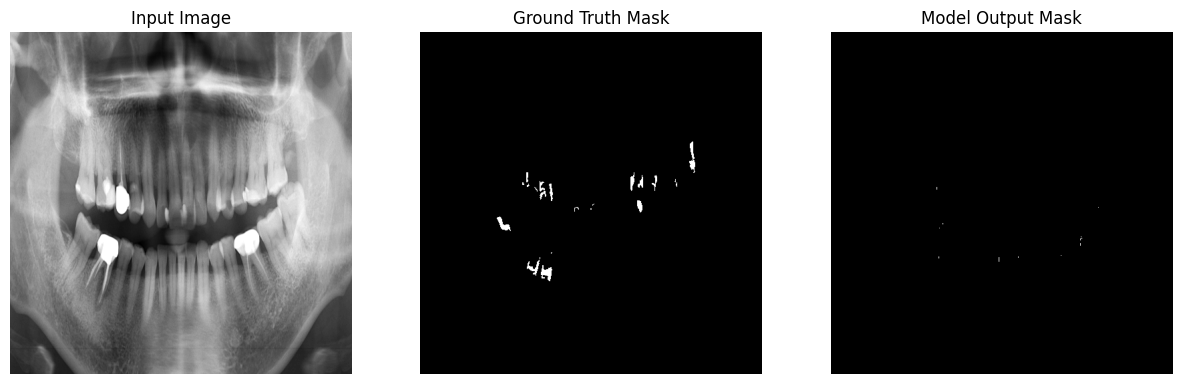

test Loss: 1.0988
Dice score: 0.0002
Epoch 2/25
----------
train Loss: 1.0993
Validation Dice improved to 0.0004. Saving model.


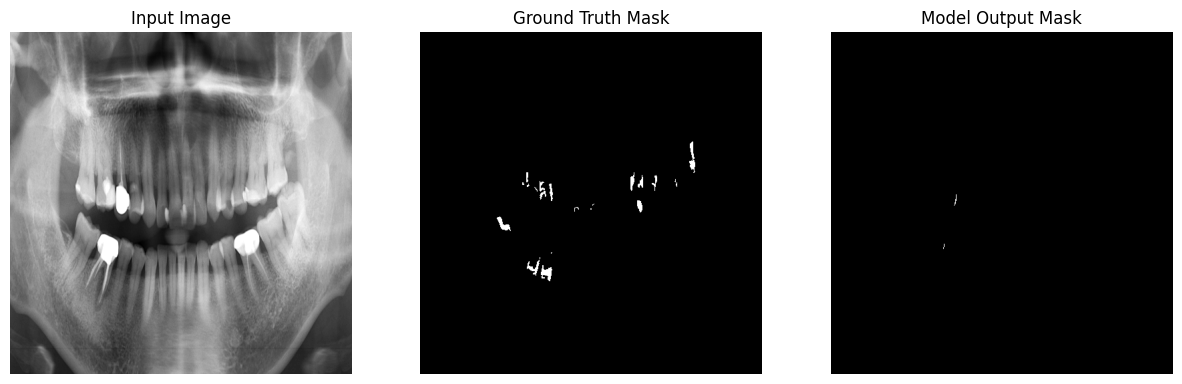

test Loss: 1.0940
Dice score: 0.0004
Epoch 3/25
----------
train Loss: 1.0990
Validation Dice improved to 0.0020. Saving model.


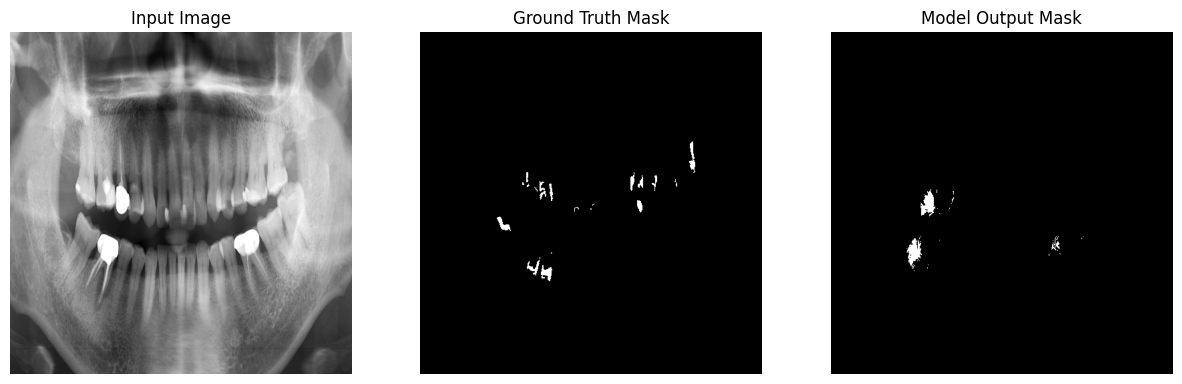

test Loss: 1.0903
Dice score: 0.0020
Epoch 4/25
----------
train Loss: 1.0988


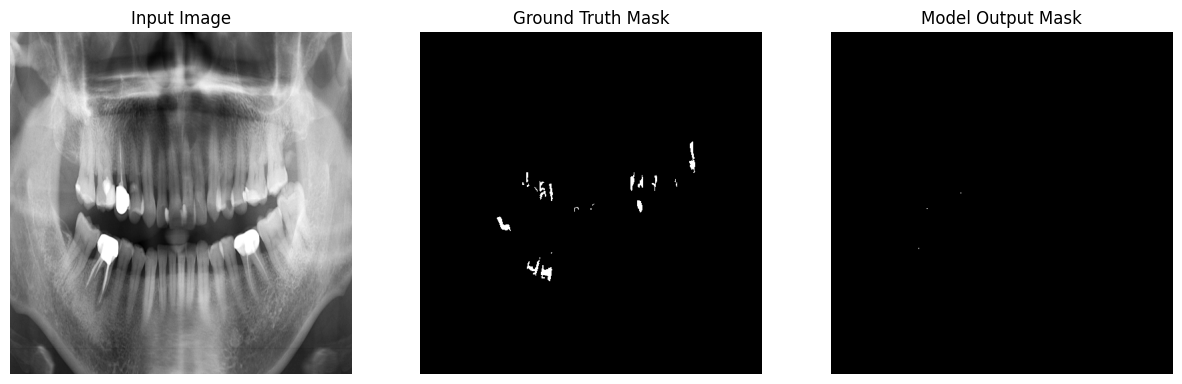

test Loss: 1.0912
Dice score: 0.0008
Epoch 5/25
----------
train Loss: 1.0990


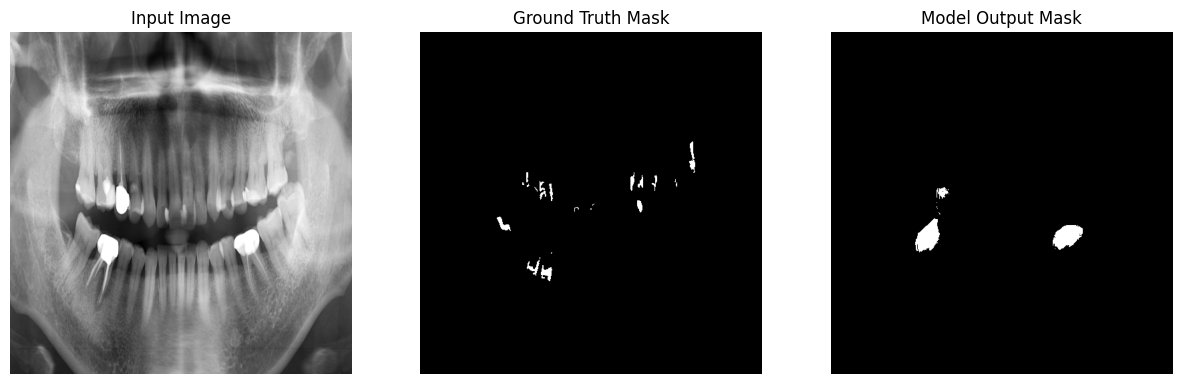

test Loss: 1.0911
Dice score: 0.0011
Epoch 6/25
----------
train Loss: 1.0988


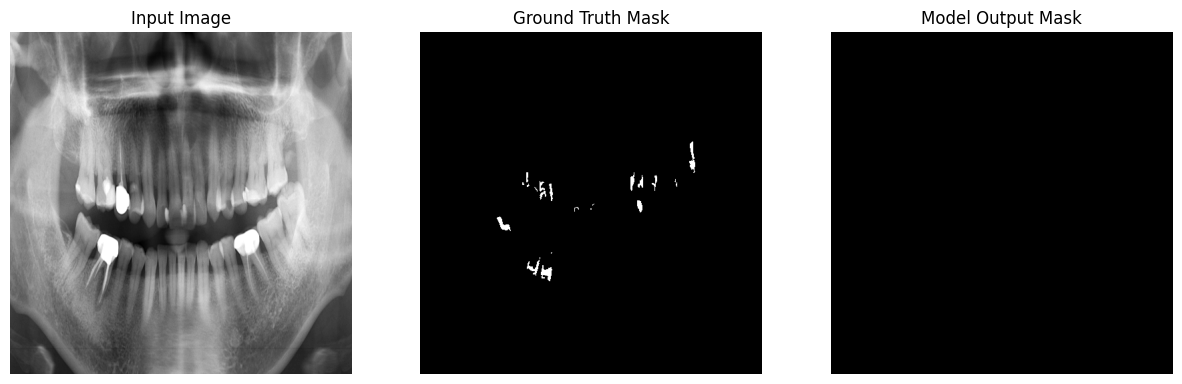

test Loss: 1.0916
Dice score: 0.0000
Epoch 7/25
----------
train Loss: 1.0987
Validation Dice improved to 0.0089. Saving model.


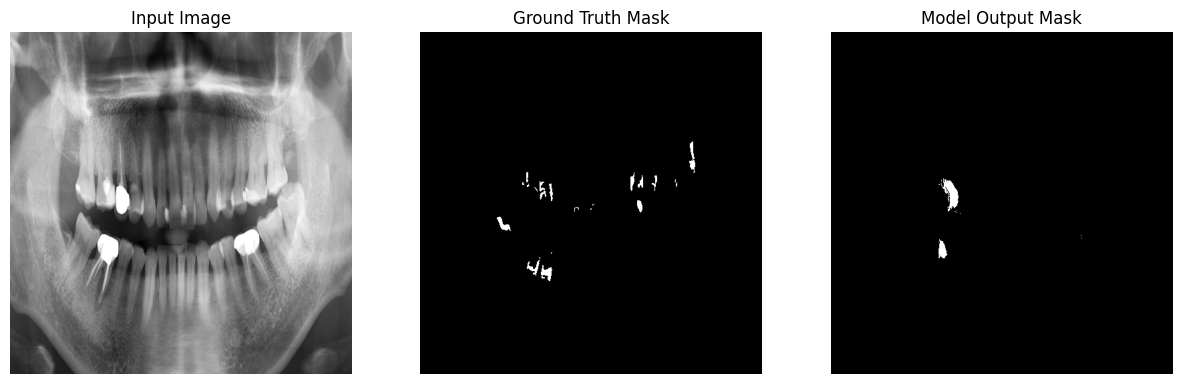

test Loss: 1.0878
Dice score: 0.0089
Epoch 8/25
----------
train Loss: 1.0989
Validation Dice improved to 0.0129. Saving model.


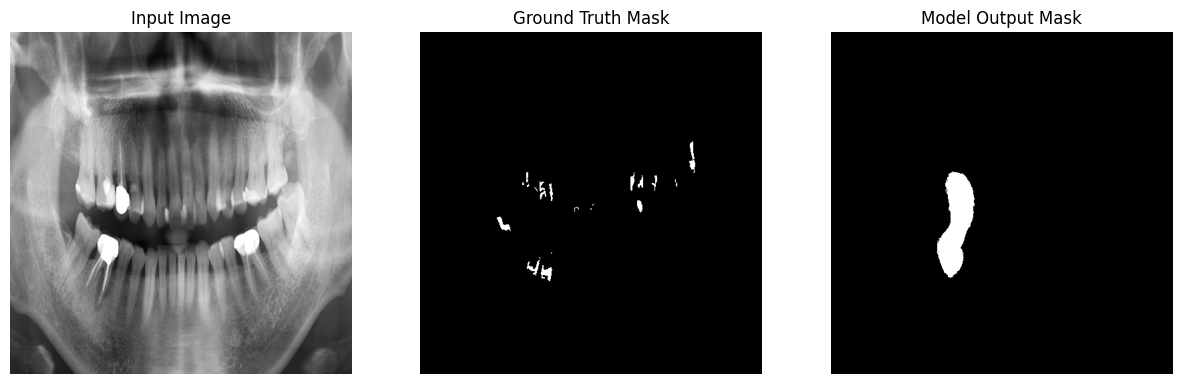

test Loss: 1.0853
Dice score: 0.0129
Epoch 9/25
----------
train Loss: 1.0975


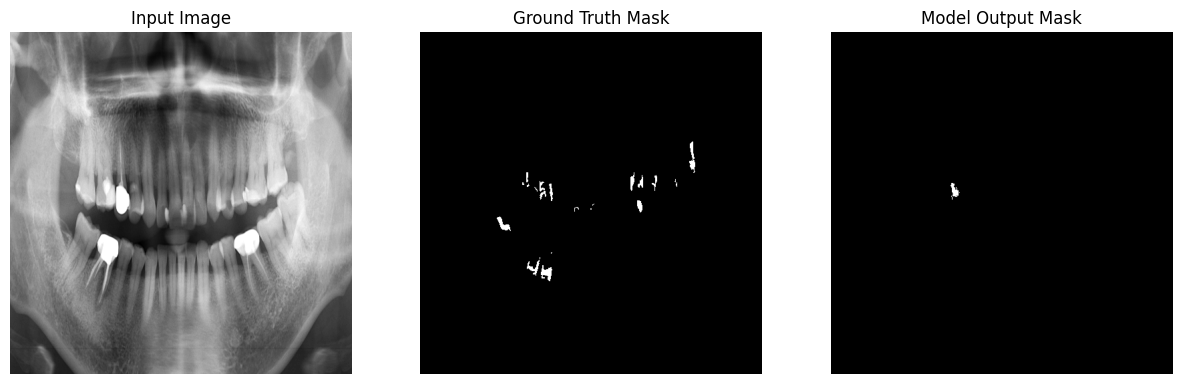

test Loss: 1.0890
Dice score: 0.0067
Epoch 10/25
----------
train Loss: 1.0987


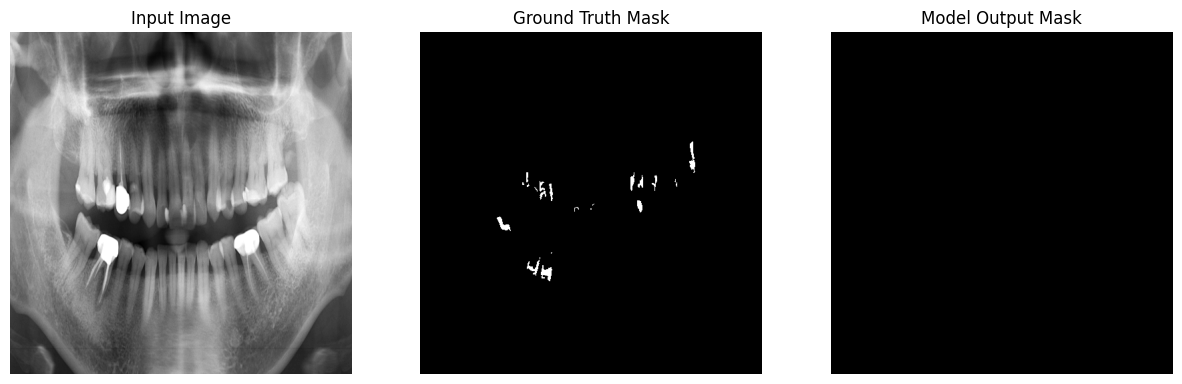

test Loss: 1.0912
Dice score: 0.0000
Epoch 11/25
----------
train Loss: 1.0973


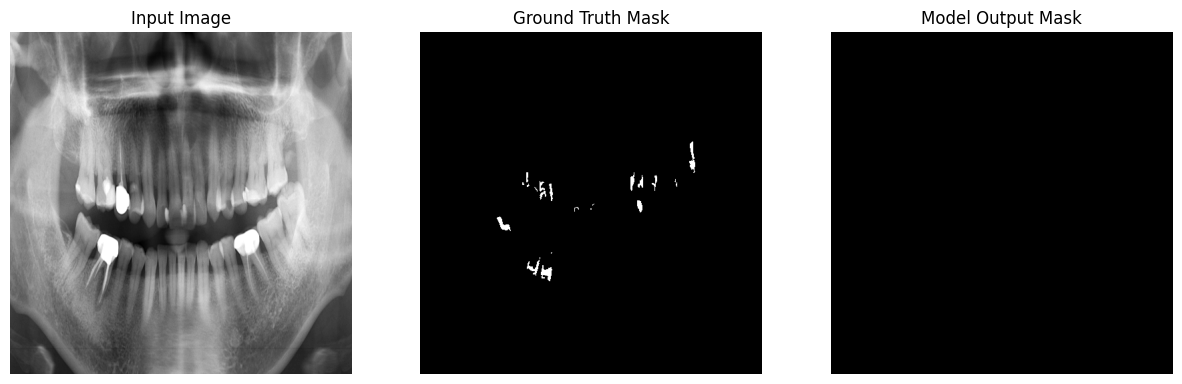

test Loss: 1.0910
Dice score: 0.0000
Epoch 12/25
----------
train Loss: 1.0992


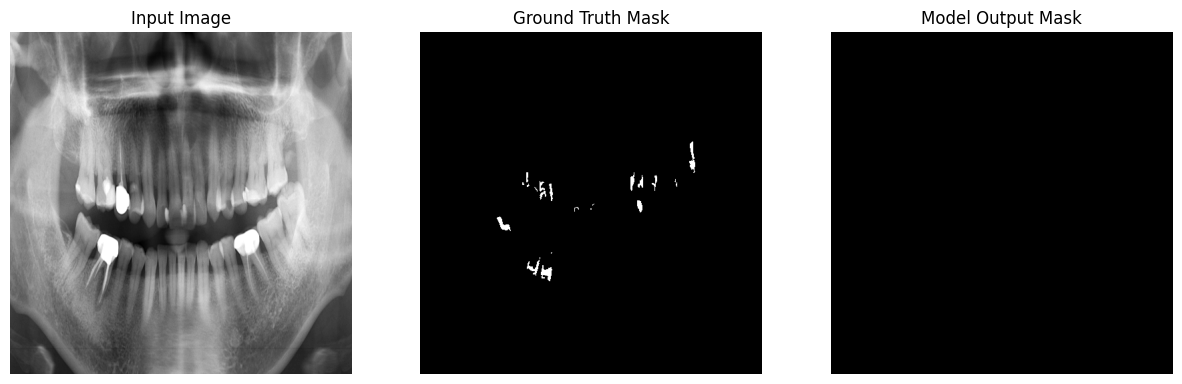

test Loss: 1.0911
Dice score: 0.0000
Epoch 13/25
----------
train Loss: 1.0985


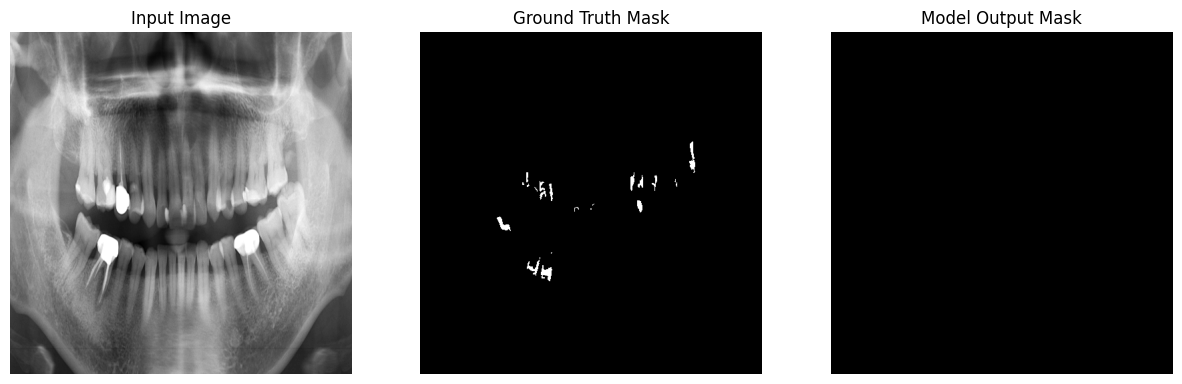

test Loss: 1.0914
Dice score: 0.0000
Epoch 14/25
----------
train Loss: 1.0987


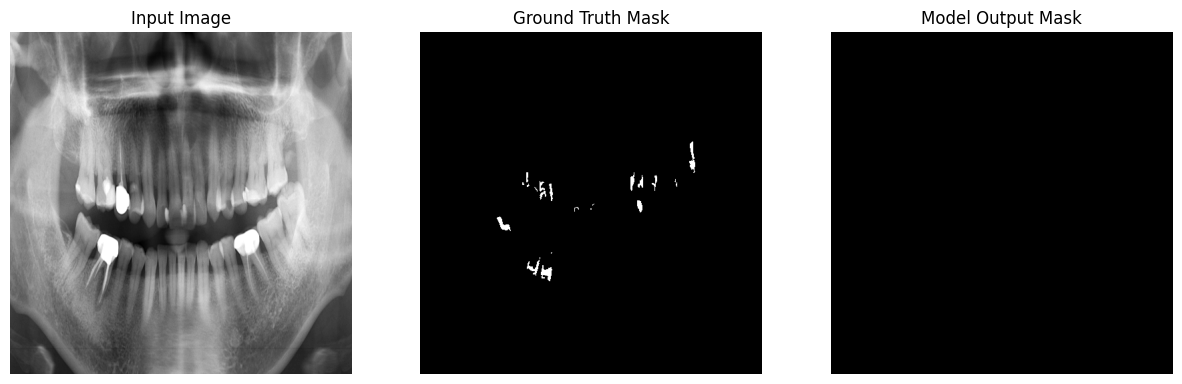

test Loss: 1.0908
Dice score: 0.0000
Epoch 15/25
----------
train Loss: 1.0985


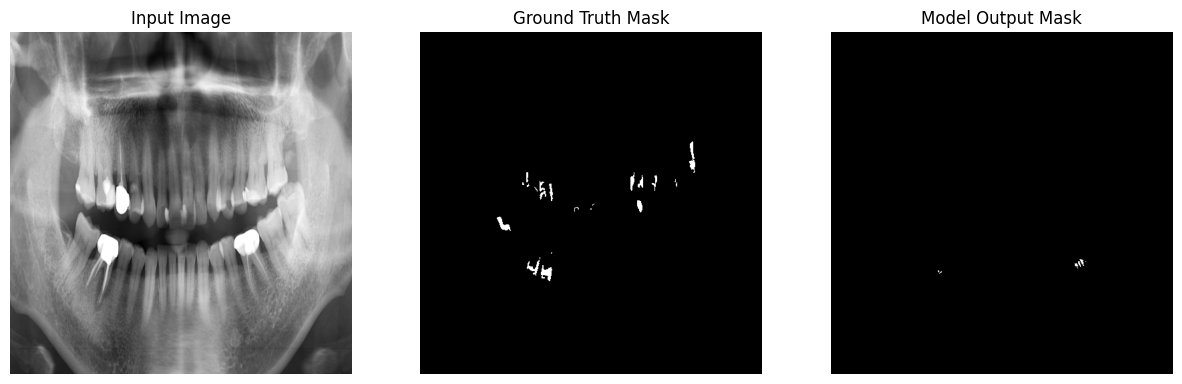

test Loss: 1.0892
Dice score: 0.0023
Epoch 16/25
----------
train Loss: 1.0987


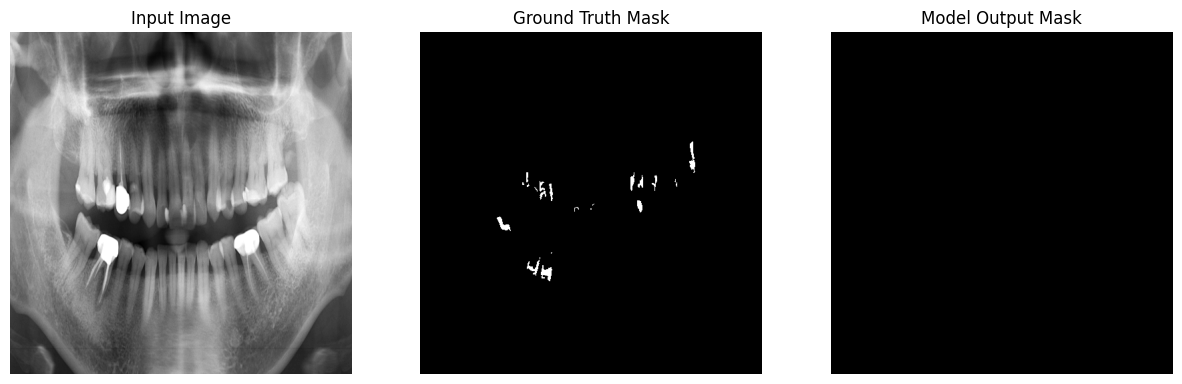

test Loss: 1.0902
Dice score: 0.0006
Epoch 17/25
----------
train Loss: 1.0986


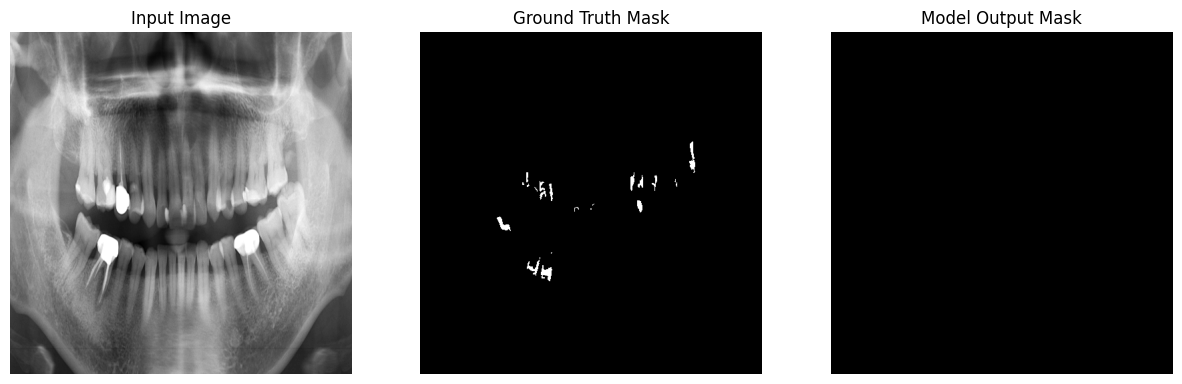

test Loss: 1.0912
Dice score: 0.0000
Epoch 18/25
----------
train Loss: 1.0975


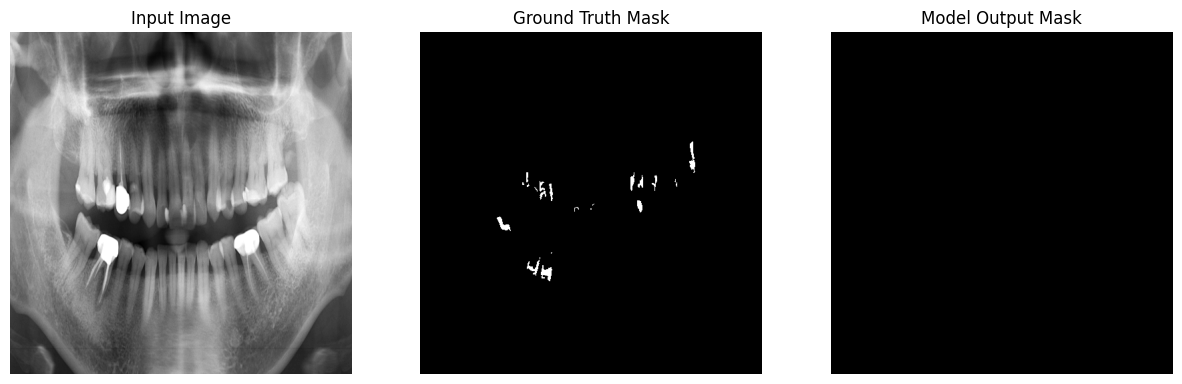

test Loss: 1.0909
Dice score: 0.0000
Epoch 19/25
----------
train Loss: 1.0988


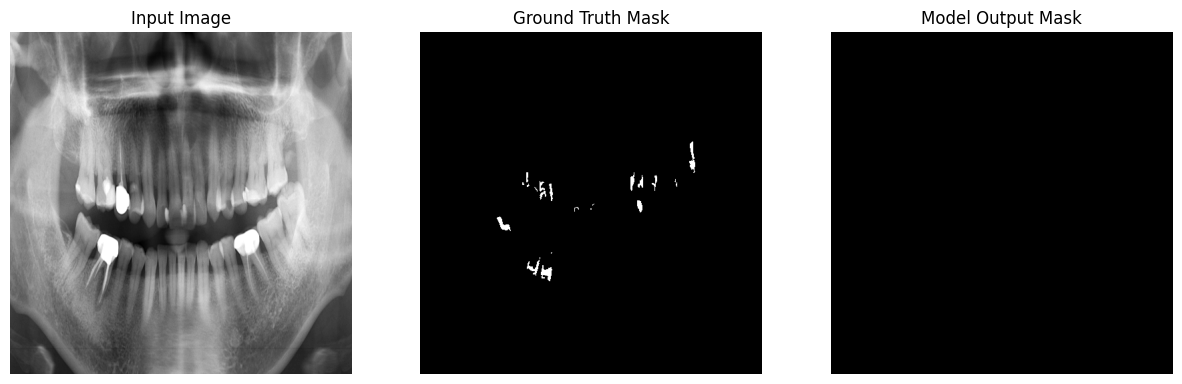

test Loss: 1.0914
Dice score: 0.0000
Epoch 20/25
----------
train Loss: 1.0988


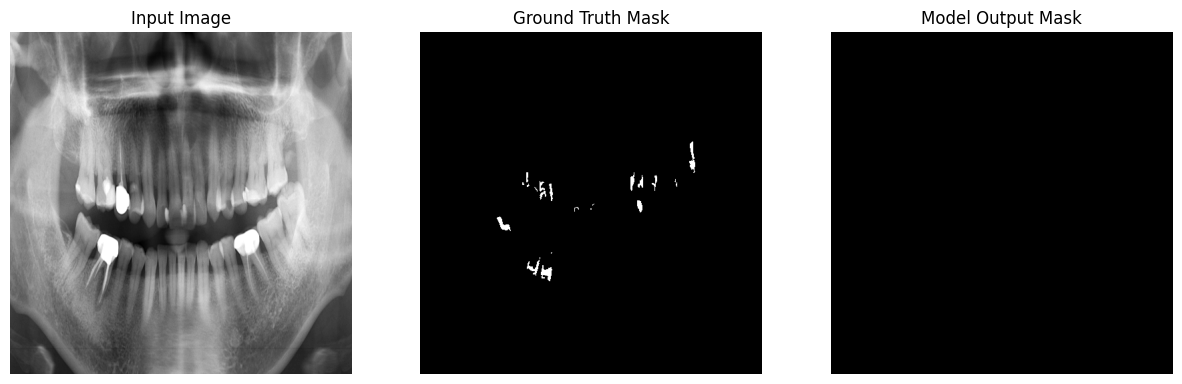

test Loss: 1.0909
Dice score: 0.0000
Epoch 21/25
----------
train Loss: 1.0987


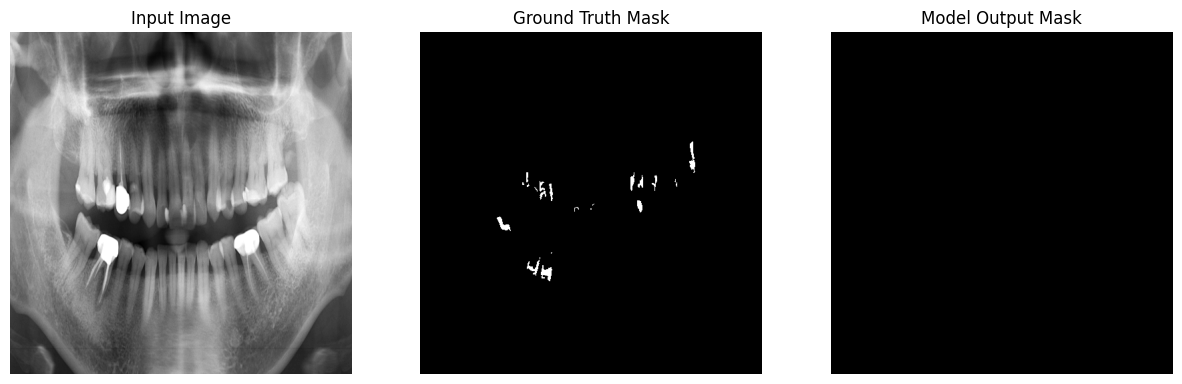

test Loss: 1.0913
Dice score: 0.0001
Epoch 22/25
----------
train Loss: 1.0987


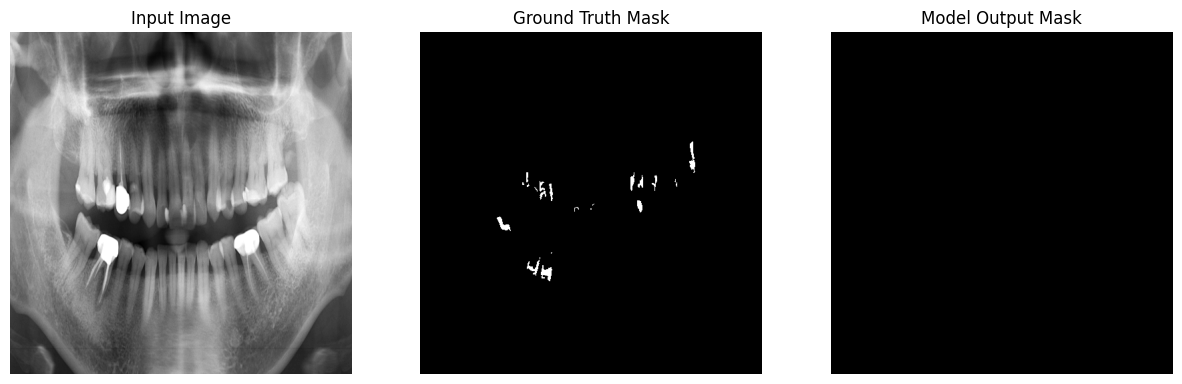

test Loss: 1.0908
Dice score: 0.0000
Epoch 23/25
----------
train Loss: 1.0980


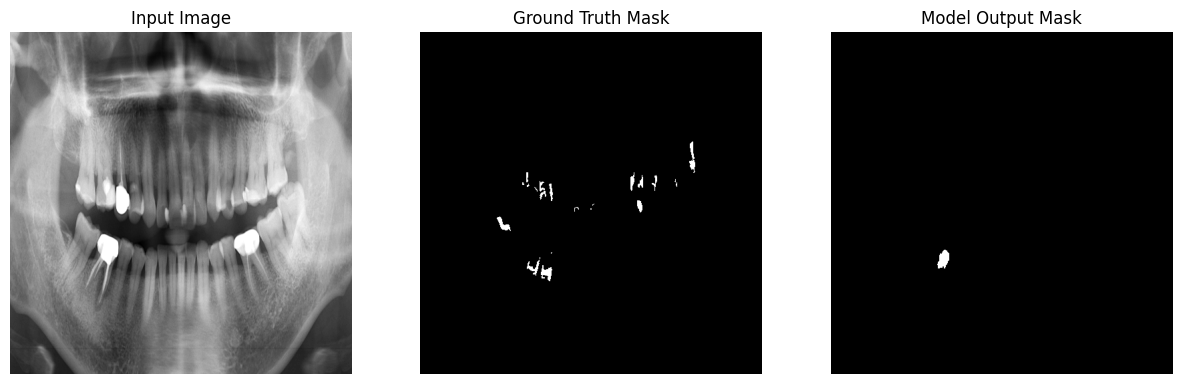

test Loss: 1.0896
Dice score: 0.0036
Epoch 24/25
----------
train Loss: 1.0985


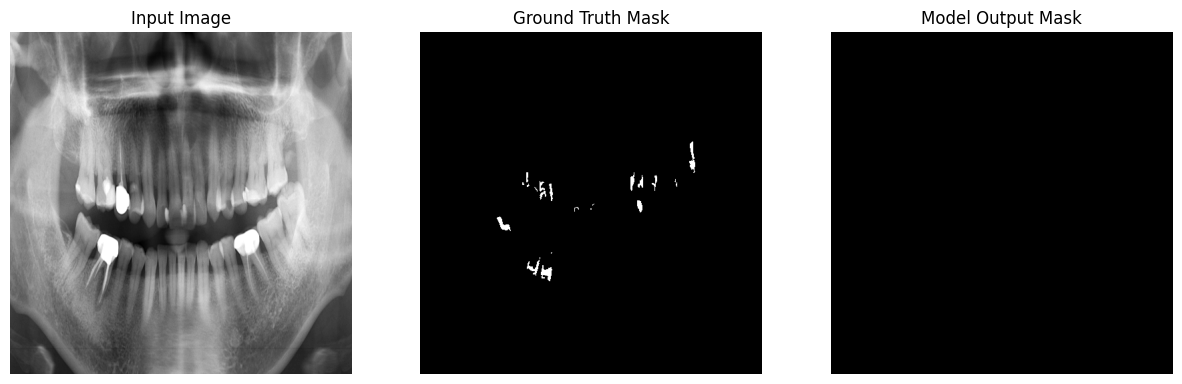

test Loss: 1.0922
Dice score: 0.0000
Epoch 25/25
----------
train Loss: 1.0994


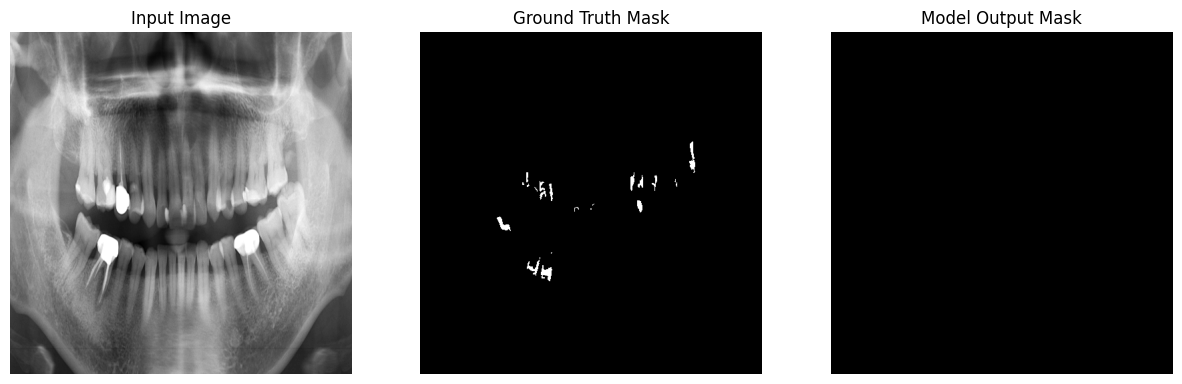

test Loss: 1.0914
Dice score: 0.0000
Training complete in 11m 16s


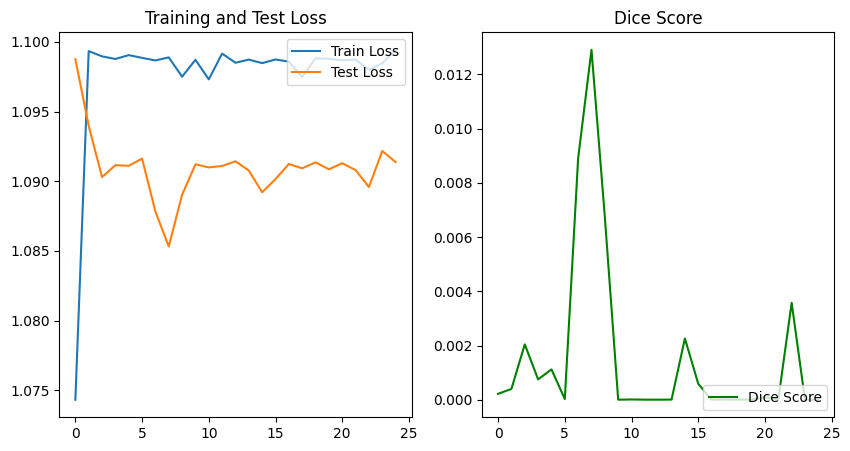

Model saved to model.pth with size 29.99 MB


In [ ]:
# import os
# import numpy as np
# from PIL import Image
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import time
# from torch.utils.data import Dataset, DataLoader
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# from model import Model  # Ensure model.py is in the same directory
# import matplotlib.pyplot as plt

# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Define the split ratio
# split_ratio = 0.8

# # Define the TeethSegmentationDataset
# class TeethSegmentationDataset(Dataset):
#     def __init__(self, image_dir: str, mask_dir: str, transform: A.Compose, dataset_type: str = 'Train', noisy_masks: list = None):
#         """
#         Args:
#             image_dir (str): Directory path containing input images.
#             mask_dir (str): Directory path containing corresponding segmentation masks.
#             transform (callable): Transformation to be applied to both image and mask.
#             dataset_type (str, optional): 'Train' or 'Test'. Defaults to 'Train'.
#             noisy_masks (list, optional): List of mask filenames to exclude. Defaults to None.
#         """
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.transform = transform
#         self.dataset_type = dataset_type

#         self.images = sorted(os.listdir(image_dir))
#         self.masks = sorted(os.listdir(mask_dir))

#         if noisy_masks:
#             self.images = [img for img in self.images if img not in noisy_masks]
#             self.masks = [mask for mask in self.masks if mask not in noisy_masks]

#         assert len(self.images) == len(self.masks), "Number of images and masks do not match!"

#         number_of_samples = len(self.images)

#         if dataset_type == 'Train':
#             self.images = self.images[:int(number_of_samples * split_ratio)]
#             self.masks = self.masks[:int(number_of_samples * split_ratio)]
#         elif dataset_type == 'Test':
#             self.images = self.images[int(number_of_samples * split_ratio):]
#             self.masks = self.masks[int(number_of_samples * split_ratio):]

#     def __len__(self) -> int:
#         return len(self.images)

#     def __getitem__(self, index: int) -> tuple:
#         image_path = os.path.join(self.image_dir, self.images[index])
#         mask_path = os.path.join(self.mask_dir, self.masks[index])

#         # Load image and mask as grayscale
#         image = np.array(Image.open(image_path).convert("L"))
#         mask = np.array(Image.open(mask_path).convert("L"))

#         transformed = self.transform(image=image, mask=mask)
#         image = transformed['image']
#         mask = transformed['mask']

#         binary_mask = (mask > 0).float().unsqueeze(0)  # Shape: (1, H, W)

#         return image, binary_mask

# # Enhanced Data Augmentation
# augmenter = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.Rotate(limit=30, p=0.5),
#     A.ElasticTransform(alpha=120, sigma=6, alpha_affine=20, p=0.5),
#     A.GridDistortion(p=0.5),
#     A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.RandomGamma(p=0.5),
#     A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
#     A.Blur(blur_limit=3, p=0.2),
#     A.MotionBlur(blur_limit=3, p=0.2),
#     A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),
#     ToTensorV2(),
# ])

# test_augmenter = A.Compose([
#     A.Normalize(mean=(0.5,), std=(0.5,), max_pixel_value=255.0),
#     ToTensorV2(),
# ])

# # Initialize datasets and dataloaders
# train_dataset = TeethSegmentationDataset(
#     image_dir="./Main_teeth_dataset/images",
#     mask_dir="./Main_teeth_dataset/labels",
#     transform=augmenter,
#     dataset_type='Train',
# )

# test_dataset = TeethSegmentationDataset(
#     image_dir="./Main_teeth_dataset/images",
#     mask_dir="./Main_teeth_dataset/labels",
#     transform=test_augmenter,
#     dataset_type='Test',
# )

# batch_size = 8  # Adjust based on your GPU's capability
# num_workers = 2  # Adjust based on system recommendation

# dataloaders = {
#     'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True),
#     'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
# }

# print(f"Train dataset size: {len(train_dataset)}")
# print(f"Test dataset size: {len(test_dataset)}")

# # Define Dice Score Function
# def dice_score(pred: torch.Tensor, target_mask: torch.Tensor, epsilon: float = 1e-6) -> float:
#     pred = (pred > 0.5).float()
#     pred_flat = pred.view(pred.shape[0], -1)
#     target_flat = target_mask.view(target_mask.shape[0], -1)

#     intersection = (pred_flat * target_flat).sum(dim=1)
#     union = pred_flat.sum(dim=1) + target_flat.sum(dim=1)

#     dice = (2. * intersection + epsilon) / (union + epsilon)

#     return dice.mean().item()

# # Define Focal Loss
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.8, gamma=2):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.bce = nn.BCEWithLogitsLoss(reduction='none')

#     def forward(self, inputs, targets):
#         BCE_loss = self.bce(inputs, targets)
#         pt = torch.exp(-BCE_loss)
#         F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
#         return F_loss.mean()

# # Define combined loss function (Focal Loss + Dice Loss)
# class FocalDiceLoss(nn.Module):
#     def __init__(self, alpha=0.8, gamma=2):
#         super(FocalDiceLoss, self).__init__()
#         self.focal = FocalLoss(alpha, gamma)

#     def forward(self, inputs, targets):
#         focal_loss = self.focal(inputs, targets)
#         # Convert logits to probabilities
#         probs = torch.sigmoid(inputs)
#         # Calculate Dice coefficient
#         pred = probs
#         dice = dice_score(pred, targets)
#         dice_loss = 1 - dice
#         return focal_loss + dice_loss

# criterion = FocalDiceLoss(alpha=0.8, gamma=2)

# # Initialize the model
# model = Model()
# model = model.to(device)

# # Define Optimizer
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

# # Training function
# def train_model(
#     model: nn.Module,
#     dataloaders: dict,
#     criterion: nn.Module,
#     optimizer: optim.Optimizer,
#     num_epochs: int = 25
# ) -> nn.Module:
#     since = time.time()

#     train_losses = []
#     test_losses = []
#     dice_scores_epoch = []

#     best_dice = 0.0
#     best_model_wts = None

#     for epoch in range(num_epochs):
#         dice_scores = []
#         print(f'Epoch {epoch+1}/{num_epochs}')
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'test']:
#             if phase == 'train':
#                 model.train()  # Set model to training mode
#             else:
#                 model.eval()   # Set model to evaluate mode

#             running_loss = 0.0

#             # Iterate over data
#             for inputs, masks in dataloaders[phase]:
#                 inputs = inputs.to(device)
#                 masks = masks.to(device)

#                 # Zero the parameter gradients
#                 optimizer.zero_grad()

#                 # Forward
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = model(inputs)

#                     loss = criterion(outputs, masks)

#                     # Backward + optimize only if in training phase
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()
#                     else:
#                         # Calculate dice score
#                         probs = torch.sigmoid(outputs)
#                         dice = dice_score(probs, masks)
#                         dice_scores.append(dice)

#                 # Statistics
#                 running_loss += loss.item() * inputs.size(0)

#             epoch_loss = running_loss / len(dataloaders[phase].dataset)
#             if phase == 'train':
#                 train_losses.append(epoch_loss)
#             else:
#                 test_losses.append(epoch_loss)
#                 epoch_dice = np.mean(dice_scores)
#                 dice_scores_epoch.append(epoch_dice)

#                 if epoch_dice > best_dice:
#                     best_dice = epoch_dice
#                     best_model_wts = model.state_dict()
#                     torch.save(best_model_wts, 'best_model.pth')
#                     print(f'Validation Dice improved to {best_dice:.4f}. Saving model.')

#                 visualize_mask(inputs, masks, outputs)

#             print(f'{phase} Loss: {epoch_loss:.4f}')
#             if phase == 'test':
#                 print(f'Dice score: {epoch_dice:.4f}')

#     time_elapsed = time.time() - since
#     print(f'Training complete in {int(time_elapsed // 60)}m {int(time_elapsed % 60)}s')

#     # Load best model weights
#     if best_model_wts:
#         model.load_state_dict(best_model_wts)

#     # Plot the results
#     epochs_range = range(num_epochs)
#     plt.figure(figsize=(10, 5))

#     plt.subplot(1, 2, 1)
#     plt.plot(epochs_range, train_losses, label="Train Loss")
#     plt.plot(epochs_range, test_losses, label="Test Loss")
#     plt.legend(loc="upper right")
#     plt.title("Training and Test Loss")

#     plt.subplot(1, 2, 2)
#     plt.plot(epochs_range, dice_scores_epoch, label="Dice Score", color="green")
#     plt.legend(loc="lower right")
#     plt.title("Dice Score")

#     plt.show()

#     return model

# # Visualization Function
# def visualize_mask(inputs: torch.Tensor, masks: torch.Tensor, outputs: torch.Tensor):
#     sample_index = 0  # Index of the sample to visualize

#     inputs_np = inputs.cpu().numpy()
#     masks_np = masks.cpu().numpy()
#     outputs_np = torch.sigmoid(outputs).detach().cpu().numpy()

#     # Plotting
#     plt.figure(figsize=(15, 5))

#     plt.subplot(1, 3, 1)
#     plt.imshow(inputs_np[sample_index][0], cmap='gray')  # Assuming inputs are in CxHxW format
#     plt.title("Input Image")
#     plt.axis('off')

#     plt.subplot(1, 3, 2)
#     plt.imshow(masks_np[sample_index][0], cmap='gray')  # Display the mask
#     plt.title("Ground Truth Mask")
#     plt.axis('off')

#     plt.subplot(1, 3, 3)
#     plt.imshow(outputs_np[sample_index][0] > 0.5, cmap='gray')  # Display the output
#     plt.title("Model Output Mask")
#     plt.axis('off')

#     plt.show()

# # Train the model
# model = train_model(model, dataloaders, criterion, optimizer, num_epochs=25)

# # Save the trained model
# model_save_path = "model.pth"
# torch.save(model.cpu().state_dict(), model_save_path)
# model_size = os.path.getsize(model_save_path) / (1024 * 1024)
# print(f"Model saved to {model_save_path} with size {model_size:.2f} MB")


In [ ]:
# # train.py

# import os
# import numpy as np
# from PIL import Image
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
# import torch.optim as optim
# import time
# import cv2
# from torch.cuda.amp import autocast, GradScaler
# import segmentation_models_pytorch as smp

# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Dataset Class
# class TeethSegmentationDataset(Dataset):
#     def __init__(self, image_dir: str, mask_dir: str, transform: A.Compose, dataset_type: str = 'Train'):
#         self.image_dir = image_dir
#         self.mask_dir = mask_dir
#         self.transform = transform
#         self.dataset_type = dataset_type

#         self.images = sorted(os.listdir(image_dir))
#         self.masks = sorted(os.listdir(mask_dir))
#         number_of_samples = len(self.images)

#         split_ratio = 0.8
#         split_index = int(number_of_samples * split_ratio)
#         if dataset_type == 'Train':
#             self.images = self.images[:split_index]
#             self.masks = self.masks[:split_index]
#         elif dataset_type == 'Test':
#             self.images = self.images[split_index:]
#             self.masks = self.masks[split_index:]

#     def __len__(self):
#         return len(self.images)

#     def denoise_mask(self, mask):
#         mask = mask.astype(np.uint8)
#         kernel = np.ones((3,3), np.uint8)
#         mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
#         mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
#         return mask

#     def __getitem__(self, index):
#         image_path = os.path.join(self.image_dir, self.images[index])
#         mask_path = os.path.join(self.mask_dir, self.masks[index])

#         image = np.array(Image.open(image_path).convert("L"))
#         mask = np.array(Image.open(mask_path).convert("L"))

#         # تبدیل تصویر خاکستری به 3 کاناله
#         image = np.stack([image]*3, axis=-1)  # شکل: (H, W, 3)

#         # مدیریت نویز در ماسک
#         mask = self.denoise_mask(mask)

#         transformed = self.transform(image=image, mask=mask)
#         image = transformed['image']
#         mask = transformed['mask']

#         # Ensure binary mask with channel dimension
#         binary_mask = (mask > 0.5).float()

#         if binary_mask.dim() == 2:
#             binary_mask = binary_mask.unsqueeze(0)

#         return image, binary_mask

# # Data Augmentation with advanced techniques
# train_transform = A.Compose([
#     A.Resize(512, 512),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.ElasticTransform(alpha=1, sigma=50, approximate=True, p=0.3),
#     A.GaussianBlur(blur_limit=(3, 7), p=0.2),
#     A.GridDistortion(p=0.3),
#     A.RandomResizedCrop(512, 512, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5),
#     A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.5),
#     A.ColorJitter(p=0.5),
#     A.Normalize(mean=(0.485, 0.456, 0.406),  # ImageNet mean
#                 std=(0.229, 0.224, 0.225),
#                 max_pixel_value=255.0),
#     ToTensorV2(),
# ])

# test_transform = A.Compose([
#     A.Resize(512, 512),
#     A.Normalize(mean=(0.485, 0.456, 0.406),  # ImageNet mean
#                 std=(0.229, 0.224, 0.225),
#                 max_pixel_value=255.0),
#     ToTensorV2(),
# ])

# # Initialize Datasets and DataLoaders
# train_dataset = TeethSegmentationDataset(
#     image_dir="./Main_teeth_dataset/images",
#     mask_dir="./Main_teeth_dataset/labels",
#     transform=train_transform,
#     dataset_type='Train',
# )

# test_dataset = TeethSegmentationDataset(
#     image_dir="./Main_teeth_dataset/images",
#     mask_dir="./Main_teeth_dataset/labels",
#     transform=test_transform,
#     dataset_type='Test',
# )

# batch_size = 8  # افزایش batch size با توجه به حافظه GPU
# num_workers = 4

# dataloaders = {
#     'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True),
#     'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
# }

# print(f"Train dataset size: {len(train_dataset)}")
# print(f"Test dataset size: {len(test_dataset)}")

# # Model Initialization using pre-trained DeepLabV3+
# model = smp.DeepLabV3Plus(
#     encoder_name='resnet34',        # انتخاب انکودر، می‌توانید انکودرهای دیگر را امتحان کنید
#     encoder_weights='imagenet',     # استفاده از وزن‌های از پیش آموزش‌دیده روی ImageNet
#     in_channels=3,                  # تعداد کانال‌های ورودی (3 برای تصاویر RGB)
#     classes=1,                      # تعداد کلاس‌های خروجی (1 برای تقسیم‌بندی دودویی)
# )

# model = model.to(device)

# # Define Optimizer
# optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# # Learning Rate Scheduler with Warm-up and Cosine Annealing
# scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# # Loss Functions
# # Focal Loss
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=0.8, gamma=2):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.bce_loss = nn.BCEWithLogitsLoss()

#     def forward(self, inputs, targets):
#         BCE_loss = self.bce_loss(inputs, targets)
#         pt = torch.exp(-BCE_loss)
#         F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
#         return F_loss

# # Dice Loss
# class DiceLoss(nn.Module):
#     def __init__(self, smooth=1):
#         super(DiceLoss, self).__init__()
#         self.smooth = smooth

#     def forward(self, inputs, targets):
#         inputs = torch.sigmoid(inputs)
#         inputs = inputs.view(-1)
#         targets = targets.view(-1)
#         intersection = (inputs * targets).sum()
#         dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
#         return 1 - dice

# # Combined Loss
# def combined_loss(inputs, targets):
#     dice = DiceLoss()(inputs, targets)
#     focal = FocalLoss()(inputs, targets)
#     return dice + focal

# # Dice Score Function
# def dice_score(pred: torch.Tensor, target_mask: torch.Tensor, epsilon: float = 1e-6) -> float:
#     pred = torch.sigmoid(pred) > 0.5
#     target_mask = target_mask > 0.5
#     pred_flat = pred.view(-1).float()
#     target_flat = target_mask.view(-1).float()
#     intersection = (pred_flat * target_flat).sum()
#     dice = (2. * intersection + epsilon) / (pred_flat.sum() + target_flat.sum() + epsilon)
#     return dice.item()

# # Training Function with Early Stopping
# def train_model(model: nn.Module, dataloaders: dict, optimizer: optim.Optimizer, scheduler, num_epochs: int = 50, early_stopping_patience: int = 7) -> nn.Module:
#     since = time.time()

#     best_dice = 0.0
#     best_model_wts = None
#     train_losses = []
#     test_losses = []
#     dice_scores_epoch = []
#     epochs_no_improve = 0

#     scaler = GradScaler()

#     for epoch in range(num_epochs):
#         print(f'Epoch {epoch+1}/{num_epochs}')
#         print('-' * 10)

#         # Each epoch has a training and validation phase
#         for phase in ['train', 'test']:
#             if phase == 'train':
#                 model.train()
#             else:
#                 model.eval()

#             running_loss = 0.0
#             running_dice = 0.0

#             for inputs, masks in dataloaders[phase]:
#                 inputs = inputs.to(device, non_blocking=True)
#                 masks = masks.to(device, non_blocking=True)

#                 optimizer.zero_grad()

#                 with torch.set_grad_enabled(phase == 'train'):
#                     with autocast():
#                         outputs = model(inputs)
#                         loss = combined_loss(outputs, masks)

#                     if phase == 'train':
#                         scaler.scale(loss).backward()
#                         scaler.step(optimizer)
#                         scaler.update()

#                 running_loss += loss.item() * inputs.size(0)

#                 if phase == 'test':
#                     running_dice += dice_score(outputs, masks) * inputs.size(0)

#                 # Free up memory
#                 del inputs, masks, outputs, loss
#                 torch.cuda.empty_cache()

#             epoch_loss = running_loss / len(dataloaders[phase].dataset)
#             if phase == 'train':
#                 train_losses.append(epoch_loss)
#                 scheduler.step(epoch + epoch_loss)
#             else:
#                 test_losses.append(epoch_loss)
#                 epoch_dice = running_dice / len(dataloaders['test'].dataset)
#                 dice_scores_epoch.append(epoch_dice)

#                 print(f'{phase} Loss: {epoch_loss:.4f} Dice: {epoch_dice:.4f}')

#                 # Check for improvement
#                 if epoch_dice > best_dice:
#                     best_dice = epoch_dice
#                     best_model_wts = model.state_dict()
#                     epochs_no_improve = 0
#                     torch.save(best_model_wts, 'model.pth')
#                     print("Best model updated and saved.")
#                 else:
#                     epochs_no_improve += 1
#                     if epochs_no_improve >= early_stopping_patience:
#                         print("Early stopping triggered!")
#                         model.load_state_dict(best_model_wts)
#                         return model

#         print()

#     time_elapsed = time.time() - since
#     print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
#     print(f'Best Test Dice: {best_dice:.4f}')

#     # Load best model weights
#     if best_model_wts is not None:
#         model.load_state_dict(best_model_wts)

#     # Plot Loss and Dice Score
#     epochs_range = range(len(train_losses))
#     plt.figure(figsize=(12, 5))

#     plt.subplot(1, 2, 1)
#     plt.plot(epochs_range, train_losses, label='Train Loss')
#     plt.plot(epochs_range, test_losses, label='Test Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.title('Training and Test Loss')

#     plt.subplot(1, 2, 2)
#     plt.plot(epochs_range, dice_scores_epoch, label='Test Dice Score', color='green')
#     plt.xlabel('Epoch')
#     plt.ylabel('Dice Score')
#     plt.legend()
#     plt.title('Test Dice Score Over Epochs')

#     plt.show()

#     return model

# # Train the Model
# trained_model = train_model(model, dataloaders, optimizer, scheduler, num_epochs=50, early_stopping_patience=7)

# # Save the final model
# torch.save(trained_model.state_dict(), 'model.pth')
# print("Model saved as model.pth")


Train dataset size: 482
Test dataset size: 121


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 319MB/s]


Epoch 1/50
----------


<ipython-input-29-16eaca692186>:201: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-29-16eaca692186>:224: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


test Loss: 0.9568 Dice: 0.0880
Best model updated and saved.

Epoch 2/50
----------
test Loss: 0.9331 Dice: 0.0828

Epoch 3/50
----------
test Loss: 0.8547 Dice: 0.1594
Best model updated and saved.

Epoch 4/50
----------
test Loss: 0.8430 Dice: 0.1693
Best model updated and saved.

Epoch 5/50
----------
test Loss: 0.8066 Dice: 0.2043
Best model updated and saved.

Epoch 6/50
----------
test Loss: 0.8018 Dice: 0.2063
Best model updated and saved.

Epoch 7/50
----------
test Loss: 0.7776 Dice: 0.2311
Best model updated and saved.

Epoch 8/50
----------
test Loss: 0.7656 Dice: 0.2401
Best model updated and saved.

Epoch 9/50
----------
test Loss: 0.7598 Dice: 0.2468
Best model updated and saved.

Epoch 10/50
----------
test Loss: 0.7550 Dice: 0.2517
Best model updated and saved.

Epoch 11/50
----------
test Loss: 0.7548 Dice: 0.2519
Best model updated and saved.

Epoch 12/50
----------
test Loss: 0.7812 Dice: 0.2239

Epoch 13/50
----------
test Loss: 0.7747 Dice: 0.2295

Epoch 14/50
----

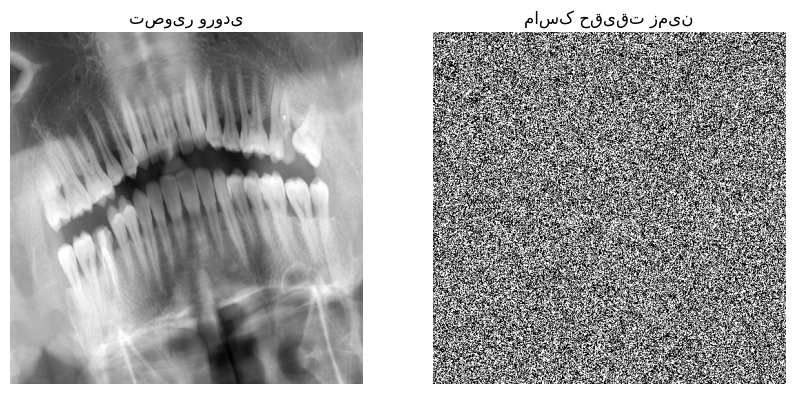

In [ ]:
# پس از تعریف Dataset و DataLoader
import matplotlib.pyplot as plt

def visualize_sample(dataset, index):
    image, mask = dataset[index]
    image_np = image.cpu().numpy().squeeze()
    mask_np = mask.cpu().numpy().squeeze()

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_np, cmap='gray')
    plt.title("تصویر ورودی")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title("ماسک حقیقت زمین")
    plt.axis('off')

    plt.show()

# نمایش یک نمونه از داده‌های آموزشی
visualize_sample(train_dataset, 0)


In [ ]:
# train.py

import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
import time
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F  # Added for functional operations

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset Class
class TeethSegmentationDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def denoise_mask(self, mask):
        mask = mask.astype(np.uint8)
        kernel = np.ones((3, 3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
        return mask

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        image = np.array(Image.open(image_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L"))

        # Denoise mask
        mask = self.denoise_mask(mask)

        # Binarize mask
        mask = (mask > 128).astype(np.float32)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Add channel dimension to mask
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)

        return image.float(), mask.float()

# Data Augmentation with advanced techniques
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Transpose(),
    A.OneOf([
        A.ElasticTransform(p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=0.5),
    ], p=0.8),
    A.ShiftScaleRotate(p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

# Initialize Datasets and DataLoaders
full_dataset = TeethSegmentationDataset(
    image_dir="./Main_teeth_dataset/images",
    mask_dir="./Main_teeth_dataset/labels",
)

# Split dataset into train and validation
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.2,
    random_state=42
)

train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)

# Assign transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform

batch_size = 4
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Model Initialization
from model import Model

model = Model().to(device)

# Define Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Loss Functions

# Lovász Hinge Loss Implementation
def lovasz_hinge(logits, labels, per_image=True):
    """
    Binary Lovász hinge loss
    """
    if per_image:
        loss = torch.mean(
            torch.stack([lovasz_hinge_flat(log.unsqueeze(0), lab.unsqueeze(0))
                         for log, lab in zip(logits, labels)])
        )
    else:
        loss = lovasz_hinge_flat(logits, labels)
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovász hinge loss
    """
    labels = labels.float()
    signs = 2.0 * labels - 1.0
    errors = 1.0 - logits * signs
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    labels_sorted = labels[perm]
    grad = lovasz_grad(labels_sorted)
    loss = torch.dot(F.relu(errors_sorted), grad)
    return loss

def lovasz_grad(labels_sorted):
    """
    Computes gradient of the Lovász extension w.r.t sorted errors
    """
    p = len(labels_sorted)
    gts = labels_sorted.sum()
    intersection = gts - labels_sorted.float().cumsum(0)
    union = gts + (1 - labels_sorted).float().cumsum(0)
    jaccard = 1.0 - intersection / union
    if p > 1:
        jaccard[1:] = jaccard[1:] - jaccard[:-1]
    return jaccard

# Dice Loss
def dice_loss(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = 1 - ((2. * intersection + smooth) /
                (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))
    return loss.mean()

# Combined Loss
def combined_loss(pred, target):
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    lovasz = lovasz_hinge_flat(pred_flat, target_flat)
    dice = dice_loss(pred, target)
    return lovasz + dice

# Training Function
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=50):
    best_loss = np.inf
    best_model_wts = None
    early_stopping_patience = 7
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training Phase
        model.train()
        train_loss = 0.0

        for inputs, masks in train_loader:
            inputs = inputs.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = combined_loss(outputs, masks)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        scheduler.step()

        epoch_train_loss = train_loss / len(train_loader.dataset)
        print(f'Train Loss: {epoch_train_loss:.4f}')

        # Validation Phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs = inputs.to(device)
                masks = masks.to(device)

                outputs = model(inputs)
                loss = combined_loss(outputs, masks)

                val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        print(f'Validation Loss: {epoch_val_loss:.4f}')

        # Check for improvement
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
            torch.save(best_model_wts, 'model.pth')
            print("Best model saved.")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print("Early stopping triggered!")
                break

        print()

    # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return model

# Train the Model
trained_model = train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=50)

# Save the final model
torch.save(trained_model.state_dict(), 'model.pth')
print("Model saved as model.pth")


Train dataset size: 482
Validation dataset size: 121
Epoch 1/50
----------
Train Loss: 2.0540
Validation Loss: 2.0058
Best model saved.

Epoch 2/50
----------
Train Loss: 2.0042
Validation Loss: 1.9977
Best model saved.

Epoch 3/50
----------
Train Loss: 1.9976
Validation Loss: 1.9945
Best model saved.

Epoch 4/50
----------
Train Loss: 1.9937
Validation Loss: 1.9910
Best model saved.

Epoch 5/50
----------
Train Loss: 1.9915
Validation Loss: 1.9896
Best model saved.

Epoch 6/50
----------
Train Loss: 1.9903
Validation Loss: 1.9880
Best model saved.

Epoch 7/50
----------
Train Loss: 1.9895
Validation Loss: 1.9872
Best model saved.

Epoch 8/50
----------
Train Loss: 1.9890
Validation Loss: 1.9868
Best model saved.

Epoch 9/50
----------
Train Loss: 1.9886
Validation Loss: 1.9867
Best model saved.

Epoch 10/50
----------
Train Loss: 1.9884
Validation Loss: 1.9866
Best model saved.

Epoch 11/50
----------
Train Loss: 1.9884
Validation Loss: 1.9866

Epoch 12/50
----------
Train Loss: 1.98

In [ ]:
# train.py

import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
import time
import cv2
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset Class
class TeethSegmentationDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def denoise_mask(self, mask):
        mask = mask.astype(np.uint8)
        kernel = np.ones((3,3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
        return mask

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        image = np.array(Image.open(image_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L"))

        # مدیریت نویز در ماسک
        mask = self.denoise_mask(mask)

        # Binarize mask
        mask = (mask > 128).astype(np.float32)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Add channel dimension to mask
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)

        return image.float(), mask.float()

# Data Augmentation with advanced techniques
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomRotate90(),
    A.Flip(),
    A.Transpose(),
    A.OneOf([
        A.ElasticTransform(p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=0.5),
    ], p=0.8),
    A.ShiftScaleRotate(p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

# Initialize Datasets and DataLoaders
full_dataset = TeethSegmentationDataset(
    image_dir="./Main_teeth_dataset/images",
    mask_dir="./Main_teeth_dataset/labels",
)

# Split dataset into train and validation
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.2,
    random_state=42
)

train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)

# Assign transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform

batch_size = 4
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Model Initialization
from model import Model

model = Model().to(device)

# Define Optimizer and Scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Loss Functions
# Lovász Loss
!pip install git+https://github.com/bermanmaxim/LovaszSoftmax
from lovasz_losses import lovasz_hinge

# Dice Loss
def dice_loss(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))
    return loss.mean()

# Combined Loss
def combined_loss(pred, target):
    lovasz = lovasz_hinge(pred, target, per_image=True)
    dice = dice_loss(pred, target)
    return lovasz + dice

# Training Function
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=50):
    best_loss = np.inf
    best_model_wts = None
    early_stopping_patience = 7
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training Phase
        model.train()
        train_loss = 0.0

        for inputs, masks in train_loader:
            inputs = inputs.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = combined_loss(outputs, masks)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        scheduler.step()

        epoch_train_loss = train_loss / len(train_loader.dataset)
        print(f'Train Loss: {epoch_train_loss:.4f}')

        # Validation Phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs = inputs.to(device)
                masks = masks.to(device)

                outputs = model(inputs)
                loss = combined_loss(outputs, masks)

                val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        print(f'Validation Loss: {epoch_val_loss:.4f}')

        # Check for improvement
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
            torch.save(best_model_wts, 'model.pth')
            print("Best model saved.")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print("Early stopping triggered!")
                break

        print()

    # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return model

# Train the Model
trained_model = train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=50)

# Save the final model
torch.save(trained_model.state_dict(), 'model.pth')
print("Model saved as model.pth")


<ipython-input-26-91f43f3bcdee>:67: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(),


Train dataset size: 482
Validation dataset size: 121
  Cloning https://github.com/bermanmaxim/LovaszSoftmax to /tmp/pip-req-build-5jusf4j3
  Running command git clone --filter=blob:none --quiet https://github.com/bermanmaxim/LovaszSoftmax /tmp/pip-req-build-5jusf4j3
  Resolved https://github.com/bermanmaxim/LovaszSoftmax to commit 7d48792d35a04d3167de488dd00daabbccd8334b
ERROR: git+https://github.com/bermanmaxim/LovaszSoftmax does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Epoch 1/50
----------


/content/lovasz_losses.py:186: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (classes is 'present' and fg.sum() == 0):


Train Loss: 2.0526
Validation Loss: 1.9998
Best model saved.

Epoch 2/50
----------
Train Loss: 1.9962
Validation Loss: 1.9913
Best model saved.

Epoch 3/50
----------
Train Loss: 1.9907
Validation Loss: 1.9873
Best model saved.

Epoch 4/50
----------
Train Loss: 1.9888
Validation Loss: 1.9863
Best model saved.

Epoch 5/50
----------
Train Loss: 1.9875
Validation Loss: 1.9850
Best model saved.

Epoch 6/50
----------
Train Loss: 1.9867
Validation Loss: 1.9845
Best model saved.

Epoch 7/50
----------
Train Loss: 1.9861
Validation Loss: 1.9841
Best model saved.

Epoch 8/50
----------
Train Loss: 1.9859
Validation Loss: 1.9840
Best model saved.

Epoch 9/50
----------
Train Loss: 1.9857
Validation Loss: 1.9837
Best model saved.

Epoch 10/50
----------
Train Loss: 1.9855
Validation Loss: 1.9837
Best model saved.

Epoch 11/50
----------
Train Loss: 1.9855
Validation Loss: 1.9837

Epoch 12/50
----------
Train Loss: 1.9855
Validation Loss: 1.9836
Best model saved.

Epoch 13/50
----------
Train 

In [ ]:
# train.py

import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
import cv2

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset Class
class TeethSegmentationDataset(Dataset):
    def __init__(self, image_dir: str, mask_dir: str, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def denoise_mask(self, mask):
        mask = mask.astype(np.uint8)
        kernel = np.ones((3,3), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
        return mask

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.masks[index])

        image = np.array(Image.open(image_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L"))

        # مدیریت نویز در ماسک
        mask = self.denoise_mask(mask)

        # Binarize mask
        mask = (mask > 128).astype(np.float32)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Add channel dimension to mask if needed
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)

        return image.float(), mask.float()

# Data Augmentation with advanced techniques
train_transform = A.Compose([
    A.Resize(256, 256),
    A.RandomResizedCrop(256, 256, scale=(0.8, 1.0), ratio=(0.9, 1.1), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=1),
    ], p=0.8),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        A.GaussianBlur(p=0.5),
        A.MotionBlur(p=0.5),
    ], p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
])

# Initialize Datasets and DataLoaders
full_dataset = TeethSegmentationDataset(
    image_dir="./Main_teeth_dataset/images",
    mask_dir="./Main_teeth_dataset/labels",
)

# Split dataset into train and validation
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.2,
    random_state=42
)

train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)

# Assign transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform

batch_size = 8  # افزایش batch_size
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Model Initialization
from model import Model

model = Model().to(device)

# Define Optimizer and Scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Loss Functions
# Lovász Loss
from lovasz_losses import lovasz_hinge

# Dice Loss
def dice_loss(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + smooth))
    return loss.mean()

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, inputs, targets):
        BCE_loss = self.bce_loss(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss

# Dice Score Function
def dice_score(pred, target, smooth=1):
    pred = torch.sigmoid(pred)
    pred = pred.contiguous()
    target = target.contiguous()
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2,3))
    score = ((2. * intersection + smooth) / (pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + smooth))
    return score.mean().item()

# Combined Loss
def combined_loss(pred, target):
    lovasz = lovasz_hinge(pred, target, per_image=True)
    dice = dice_loss(pred, target)
    focal = FocalLoss()(pred, target)
    return lovasz + dice + focal

# Training Function
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=100):
    best_loss = np.inf
    best_model_wts = None
    early_stopping_patience = 15
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training Phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0

        for inputs, masks in train_loader:
            inputs = inputs.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = combined_loss(outputs, masks)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_dice += dice_score(outputs, masks) * inputs.size(0)

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_dice = train_dice / len(train_loader.dataset)
        print(f'Train Loss: {epoch_train_loss:.4f} | Train Dice: {epoch_train_dice:.4f}')

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_dice = 0.0

        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs = inputs.to(device)
                masks = masks.to(device)

                outputs = model(inputs)
                loss = combined_loss(outputs, masks)

                val_loss += loss.item() * inputs.size(0)
                val_dice += dice_score(outputs, masks) * inputs.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_dice = val_dice / len(val_loader.dataset)
        print(f'Validation Loss: {epoch_val_loss:.4f} | Validation Dice: {epoch_val_dice:.4f}')

        # Scheduler step
        scheduler.step(epoch_val_loss)

        # Check for improvement
        if epoch_val_loss < best_loss:
            best_loss = epoch_val_loss
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
            torch.save(best_model_wts, 'model.pth')
            print("Best model saved.")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print("Early stopping triggered!")
                break

        print()

    # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return model

# حذف فایل model.pth قبل از آموزش
if os.path.exists('model.pth'):
    os.remove('model.pth')

# Train the Model
trained_model = train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs=200)

# Save the final model
torch.save(trained_model.state_dict(), 'model.pth')
print("Model saved as model.pth")


Train dataset size: 482
Validation dataset size: 121
Epoch 1/200
----------


<ipython-input-57-7890e3437af9>:71: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03, p=0.5),
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Train Loss: 2.2195 | Train Dice: 0.0204
Validation Loss: 2.1463 | Validation Dice: 0.0263
Best model saved.

Epoch 2/200
----------
Train Loss: 2.1416 | Train Dice: 0.0270
Validation Loss: 2.1344 | Validation Dice: 0.0320
Best model saved.

Epoch 3/200
----------
Train Loss: 2.1340 | Train Dice: 0.0332
Validation Loss: 2.1315 | Validation Dice: 0.0288
Best model saved.

Epoch 4/200
----------
Train Loss: 2.1307 | Train Dice: 0.0374
Validation Loss: 2.1276 | Validation Dice: 0.0449
Best model saved.

Epoch 5/200
----------
Train Loss: 2.1288 | Train Dice: 0.0430
Validation Loss: 2.1268 | Validation Dice: 0.0475
Best model saved.

Epoch 6/200
----------
Train Loss: 2.1272 | Train Dice: 0.0495
Validation Loss: 2.1244 | Validation Dice: 0.0538
Best model saved.

Epoch 7/200
----------
Train Loss: 2.1259 | Train Dice: 0.0541
Validation Loss: 2.1249 | Validation Dice: 0.0358

Epoch 8/200
----------
Train Loss: 2.1257 | Train Dice: 0.0561
Validation Loss: 2.1245 | Validation Dice: 0.0385

Epo

In [ ]:
import os

model_save_path = "model.pth"
torch.save(model.cpu().state_dict(), model_save_path)
model_size = os.path.getsize(model_save_path) / (1024 * 1024)  # Size in MB
print(f"Model saved to {model_save_path} with size {model_size:.2f} MB")


NameError: name 'model' is not defined

In [ ]:
from PIL import Image

def get_image_shape(image_path):
    # Open the image file
    with Image.open(image_path) as img:
        # Get the size of the image (width, height)
        width, height = img.size
        # Get the number of channels (mode)
        channels = len(img.getbands())
        # Print or return the shape
        print(f"Shape: ({height}, {width}, {channels})")
        return (height, width, channels)

# مثال استفاده:
image_path = '/content/Main_teeth_dataset/labels/0.png'
get_image_shape(image_path)


Shape: (512, 512, 1)


(512, 512, 1)

In [ ]:
!rm model.py model.pth submission

rm: cannot remove 'submission': No such file or directory


In [ ]:
!rm -r /content/runs

rm: cannot remove '/content/runs': No such file or directory


In [ ]:
!ls

drive  Main_teeth_dataset  model.py  __pycache__  sample_data


In [ ]:
!ls /content/Main_teeth_dataset

images	labels	Main_teeth_dataset.zip


In [ ]:
!rm -rf __pycache__

In [ ]:
!touch model.py

In [ ]:
import zipfile
import os

def zip_multiple_files(input_paths, output_zip_path, compression_level=5):
    # Ensure compression level is within 1-9
    compression_level = max(1, min(compression_level, 1))

    # Create a zip file with the specified compression level
    compression = zipfile.ZIP_DEFLATED

    # Create the zip file
    with zipfile.ZipFile(output_zip_path, 'w', compression) as zipf:
        for input_path in input_paths:
            # Check if the file or directory exists
            if not os.path.exists(input_path):
                print(f"{input_path} does not exist.")
                continue

            # If it's a directory, recursively add files
            if os.path.isdir(input_path):
                for root, dirs, files in os.walk(input_path):
                    for file in files:
                        file_full_path = os.path.join(root, file)
                        zipf.write(file_full_path,
                                   os.path.relpath(file_full_path,
                                                   os.path.join(input_path, '..')))
            # If it's a single file, add it to the zip file
            else:
                zipf.write(input_path, os.path.basename(input_path))

    print(f"Successfully zipped files to {output_zip_path} with compression level {compression_level}")

# Example usage:
input_paths = ['/content/model.py', '/content/model.pth']  # List of files or directories to zip
output_zip_path = '/content/submission8.zip'  # Path to save the output zip file
compression_level = 5  # Compression level from 1 (fastest) to 9 (most compressed)
zip_multiple_files(input_paths, output_zip_path, compression_level)


Successfully zipped files to /content/submission8.zip with compression level 1


In [ ]:
!cp /content/submission8.zip /content/drive/MyDrive/ML/Rayan/Q2/submission